In [1]:
import sys, os
sys.path.append("../../models/PFN")
sys.path.append(os.path.abspath('../../fastjet-install/lib/python3.9/site-packages'))
from dataset_pfn import PFNDataset
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from pfn_model import ParticleFlowNetwork as Model
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
all_models = [f for f in os.listdir("../../models/PFN/trained_models") if "_best" in f]
print("\n".join(all_models))

PFN_best_baseline
PFN_best_v4
PFN_best_v3


In [3]:
test_path = "../../datasets/test.h5"

#Loading testing dataset
test_set = PFNDataset(test_path, preprocessed=True)
testloader = DataLoader(test_set, shuffle=True, batch_size=512, num_workers=4, pin_memory=True, persistent_workers=True)

/u/avroy/.conda/envs/toptagger_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
def eval2(model):
    labels = []
    preds = []
    with torch.no_grad():
        for x,m,y,_ in tqdm(testloader):
            x = x.cuda()
            m = m.cuda()
            pred = model(x, m)
            labels.append(y[:,1].cpu().numpy())
            preds.append(pred[:,1].cpu().numpy())
    labels = np.concatenate(labels, axis=None)
    preds = np.concatenate(preds, axis=None)
    return labels, preds

[100, 100, 256] [100, 100, 100]


100%|██████████| 790/790 [00:25<00:00, 30.53it/s] 


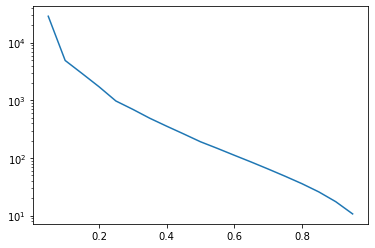

PFN_best_baseline 		 Params: 82458	 ROC-AUC: 97.98%, Accuracy: 92.84%, BRR: 698.66
[100, 64, 32] [64, 100, 100]


100%|██████████| 790/790 [00:03<00:00, 249.12it/s]


PFN_best_v4 		 Params: 27858	 ROC-AUC: 97.78%, Accuracy: 92.42%, BRR: 602.73
[100, 100, 64] [64, 100, 100]


100%|██████████| 790/790 [00:03<00:00, 239.78it/s]


PFN_best_v3 		 Params: 37926	 ROC-AUC: 97.83%, Accuracy: 92.54%, BRR: 653.44


In [5]:
for modelname in all_models:
    model_dict = json.load(open("../../models/PFN/trained_model_dicts/" + modelname.replace("_best","") + ".json"))
    label = model_dict['label']
    f_nodes = list(map(int, model_dict['f_nodes'].split(',')))
    phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))

    model = Model(input_dims=3, Phi_sizes=phi_nodes, F_sizes=f_nodes).cuda()
    model.load_state_dict(torch.load("../../models/PFN/trained_models/" + modelname ))
    nparams = sum(p.numel() for p in model.parameters())
    
    FcLayers = []
    PhiLayers = []
    for layer in model._modules['fc']:
        FcLayers.append(layer)
    for layer in model._modules['phi']:
        PhiLayers.append(layer)
    
    
    labels, preds = eval2(model)
    accuracy = accuracy_score(labels, preds.round())*100
    
    auc = roc_auc_score(labels, preds)*100
    
    fpr, tpr, thresholds = roc_curve(labels, preds, drop_intermediate=False)
    intrp = interpolate.interp1d(tpr, fpr)
    if 'baseline' in modelname:
        eS = np.array(list(range(1,20)))*0.05
        inveB = []
        for es in eS:
            inveB.append(1./intrp(es))
        plt.figure()
        plt.plot(eS, inveB)
        plt.yscale("log")
        plt.show()
    brr = 1./intrp(0.3)
    print("{} \t\t Params: {}\t ROC-AUC: {:.2f}%, Accuracy: {:.2f}%, BRR: {:.2f}".format(modelname,nparams,auc,accuracy,brr))